# Use case Moving Averages for Deep Folding projects
This use case is focused on an example of use of moving averages in deep_folding projects. <br>
Here, we suppose test skeletons have been encoded to a latent space of much fewer dimensions. <br>
We consider two cases:
- one cluster and the analysis of moving averages along one axis of this cluster,
- two clusters and the analysis of average crops of each cluster.

For this notebbok to work, you will need to point to neurospin/deep_folding folder (see root and path variable below)

### 1) Imports

In [77]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import os
import glob
import sys
import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as goroot
import pickle
import matplotlib.pyplot as plt

import deep_folding.anatomist_tools.utils.remove_hull as rhull

from soma import aims

In [78]:
root = '/neurospin' 
path = os.path.join(root, 'dico/data/deep_folding/history/2021_November/crops/SC/mask/sulcus_based/2mm/')
#path = os.path.join(root, 'dico/data/deep_folding/data/crops/STS_branches/sulcus_based/2mm/Rcrops/')
print(path)
print(os.path.isdir(path))

/neurospin/dico/data/deep_folding/history/2021_November/crops/SC/mask/sulcus_based/2mm/
True


### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (125 dimensions) for SC crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects
- projection of the subjects in a 2D space with tSNE algorithm
- export of points' coordinates

In [79]:
df_subjects = pd.read_csv('../data/visualization/sub_sort_asym_bench_sc_label.csv', index_col="id_sub").drop(columns={'Unnamed: 0'})
df_subjects.index.astype(int)
subjects = df_subjects.index
df_subjects = df_subjects.rename(columns={'91': 0, '17': 1})
assert(type(list(df_subjects.index)[0])==int)
df_subjects.head()

,0,1,label
id_sub,,,
519950,-0.287488,-0.908174,normal_test
103515,-1.600874,-0.619523,normal_test
107018,-0.873523,-3.006382,normal_test
766563,0.928389,-1.768081,normal_test
175540,-0.832408,-0.000899,normal_test


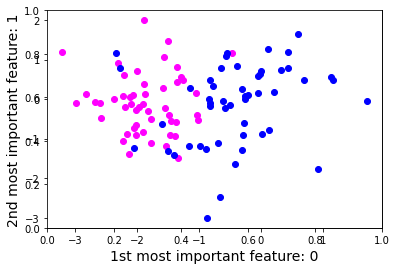

In [80]:
color_dict = {'normal_test': 'blue', 'benchmark': 'magenta'}

arr = np.array([np.array([df_subjects[k][i] for k in df_subjects.columns[:2]]) for i in df_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)
for g in np.unique([df_subjects.label]):
    ix = np.where(df_subjects.label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'1st most important feature: {df_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'2nd most important feature: {df_subjects.columns[1]}', fontsize=14)
plt.show()

### 3) Construction of dictionnary of subjects' buckets

In [81]:
print(subjects)

Int64Index([519950, 103515, 107018, 766563, 175540, 933253, 152225, 112314,
            181131, 351938, 114924, 150524, 932554, 131924, 654754, 683256,
            116524, 414229, 165032, 163836, 136631, 140117, 837964, 589567,
            220721, 154229, 951457, 108020, 558960, 397154, 557857, 548250,
            550439, 100307, 299760, 392750, 865363, 153934, 193845, 926862,
            611938, 727654, 869472, 955465, 468050, 203418, 116221, 922854,
            309636, 194443, 969476, 116726, 771354, 156031, 188145, 601127,
            307127, 163331, 317332, 211821, 257946, 194746, 206828, 161731,
            199352, 685058, 148133, 274542, 346137, 114217, 891667, 176239,
            149842, 362034, 275645, 255740, 117021, 627549, 971160, 978578,
            376247, 106521, 905147, 175439, 952863, 101006, 143224, 135730,
            176744, 983773, 117930, 146634, 613538, 130922, 177241, 568963,
            180533, 194847, 105923, 197651],
           dtype='int64', name='id_sub')


In [82]:
tgt_dir = '/tmp/test/'
dataset = rhull.DatasetHullRemoved(src_dir=path,
                                   tgt_dir=tgt_dir,
                                   side='R',
                                   list_subjects=list(subjects))
buckets = dataset.create_meshes()

SUBMITTING | :   0%|          | 0/100 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/100 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
buckets

{519950: array([[24, 23,  2],
        [29, 18,  3],
        [30, 18,  3],
        ...,
        [ 6,  4, 42],
        [ 6,  5, 42],
        [ 6,  6, 42]]), 103515: array([[30, 18,  2],
        [31, 18,  2],
        [32, 18,  2],
        ...,
        [ 6,  5, 42],
        [ 5,  6, 42],
        [ 6,  6, 42]]), 107018: array([[32, 23,  2],
        [33, 23,  2],
        [33, 24,  2],
        ...,
        [ 5,  5, 42],
        [ 6,  5, 42],
        [ 4,  4, 43]]), 766563: array([[32, 27,  2],
        [26, 17,  4],
        [26, 14,  5],
        ...,
        [ 5,  5, 42],
        [ 6,  5, 42],
        [ 4,  6, 42]]), 175540: array([[31, 14,  4],
        [25, 16,  4],
        [28, 19,  4],
        ...,
        [ 4,  5, 42],
        [ 5,  5, 42],
        [ 6,  5, 42]]), 933253: array([[33, 20,  2],
        [33, 21,  2],
        [32, 26,  2],
        ...,
        [ 6,  4, 41],
        [ 6,  5, 41],
        [ 7,  5, 41]]), 152225: array([[26, 23,  3],
        [27, 23,  3],
        [26, 24,  3],
  

In [84]:
def centeroidnp(df):
    """Gives centroid of a dataframe of points.
    /!\ Centroid is not a point within the defined set of points
    
    Args:
        IN: df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: coords: tuple of coordinates of centroid
    """
    coords = []
    ndim = len(df.columns) # number of dimensions to consider
    
    for k in range(len(df.columns)):
        arr = np.array(list(df[df.columns[k]]))
        length = arr.shape[0]
        sum_k = np.sum(arr)
        coords.append(sum_k/length)

    return tuple(coords)

In [85]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
        
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

### 4) One cluster analysis

#### Get central subject

In [86]:
centroid = centeroidnp(df_subjects[[0, 1]])
print(f"Coordinates of centroid are: {centroid}")
central = closest_distance(centroid, df_subjects[[0, 1]])
print(f"Closest subject to centroid is {central}")

Coordinates of centroid are: (-1.128909128382802, -0.11155132960528136)
Closest subject to centroid is 194847


#### Alignment of all subjects to central subject

In [87]:
aligned_buckets, aligned_rot, aligned_transl = ma.align_buckets_by_ICP_batch(buckets, central, cores=2)

>>> INFO moving_averages.transform - using 2 cores out of 48
Aligning buckets to 194847: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


In [88]:
#fig = cld.draw_numpy_buckets(list(aligned_buckets.values()), shift=(0,50,0))
#ma.plot.brochette_layout(fig)

#### Subjects histogram

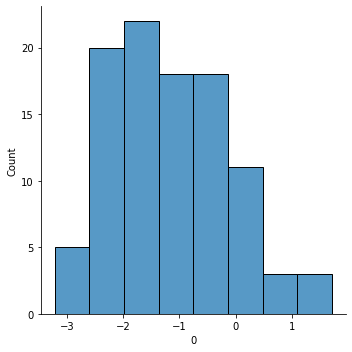

In [89]:
import seaborn as sns
sns.displot(df_subjects, x=0)

In [90]:
buckets

{519950: array([[24, 23,  2],
        [29, 18,  3],
        [30, 18,  3],
        ...,
        [ 6,  4, 42],
        [ 6,  5, 42],
        [ 6,  6, 42]]), 103515: array([[30, 18,  2],
        [31, 18,  2],
        [32, 18,  2],
        ...,
        [ 6,  5, 42],
        [ 5,  6, 42],
        [ 6,  6, 42]]), 107018: array([[32, 23,  2],
        [33, 23,  2],
        [33, 24,  2],
        ...,
        [ 5,  5, 42],
        [ 6,  5, 42],
        [ 4,  4, 43]]), 766563: array([[32, 27,  2],
        [26, 17,  4],
        [26, 14,  5],
        ...,
        [ 5,  5, 42],
        [ 6,  5, 42],
        [ 4,  6, 42]]), 175540: array([[31, 14,  4],
        [25, 16,  4],
        [28, 19,  4],
        ...,
        [ 4,  5, 42],
        [ 5,  5, 42],
        [ 6,  5, 42]]), 933253: array([[33, 20,  2],
        [33, 21,  2],
        [32, 26,  2],
        ...,
        [ 6,  4, 41],
        [ 6,  5, 41],
        [ 7,  5, 41]]), 152225: array([[26, 23,  3],
        [27, 23,  3],
        [26, 24,  3],
  

#### Creation of moving averages

In [91]:
SPAM_centers = np.arange(-3, 2, 1).astype(float) # hist des sujets => centres des moving average
# SPAM_centers = [1.]
SPAM_centers

array([-3., -2., -1.,  0.,  1.])

In [92]:
# moving_averages doesn't like string label
df_subjects['label'][:] = 0

In [93]:
df_subjects.head()

,0,1,label
id_sub,,,
519950,-0.287488,-0.908174,0
103515,-1.600874,-0.619523,0
107018,-0.873523,-3.006382,0
766563,0.928389,-1.768081,0
175540,-0.832408,-0.000899,0


In [94]:
print(type(SPAM_centers))
print(type(aligned_buckets))

<class 'numpy.ndarray'>
<class 'dict'>


In [95]:
SPAM_vols, shift = ma.calc_MA_volumes_batch(SPAM_centers, aligned_buckets, df_subjects, axis_n=0, FWHM=1)

Calculating moving averages: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


In [96]:
from tqdm import tqdm
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, smoothRate=0.3,
                    threshold="90%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)]=dtx.mesh.shift_aims_mesh_along_axis(mesh, 20*dist)

100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


#### Visualization of MA

In [97]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

#### Saving of MA

In [98]:
# for x, mesh in tqdm(shifted_SPAM_meshes.items()):
#     aims.write(mesh, f"MA_{x}_sc.mesh")

### 5) 2 clusters analysis

#### Loading of subjects of the two clusters

In [99]:
tsne_subjects = pd.read_csv('../data/visualization/tsne_asym_bench_sc.csv', index_col="id_sub").drop(columns={'Unnamed: 0'})
subjects_tsne = tsne_subjects.index
tsne_subjects = tsne_subjects.rename(columns={'tsne: 0': 0, 'tsne: 1': 1})
tsne_subjects.head()

,0,1,label
id_sub,,,
519950,4.008054,-1.621285,normal_test
103515,2.547560,-5.097945,normal_test
107018,1.798697,2.676100,normal_test
766563,6.575020,1.122650,normal_test
175540,2.784817,-0.695892,normal_test


We can use labels if we have them (in the case where we use benchmark subjects vs controls for example):

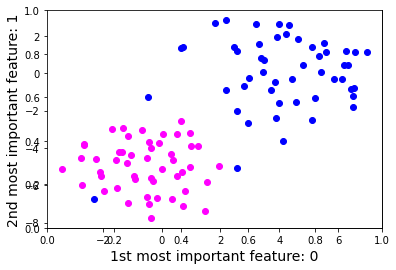

In [100]:
color_dict = {'normal_test': 'blue', 'benchmark': 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)
for g in np.unique([tsne_subjects.label]):
    ix = np.where(tsne_subjects.label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'1st most important feature: {tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'2nd most important feature: {tsne_subjects.columns[1]}', fontsize=14)
plt.show()

We can also imagine a case where we don't have any labels but two clusters and apply a kmeans algorithm:

In [101]:
from sklearn.cluster import KMeans

X = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

labels = kmeans.labels_
tsne_subjects['kmeans_label'] = labels
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[-0.5277442  -4.92195076]
 [ 4.31508814  0.23949671]]


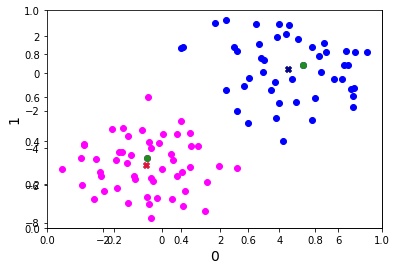

In [102]:
color_dict = {1: 'blue', 0: 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)

for g in np.unique(kmeans.labels_):
    ix = np.where(kmeans.labels_ == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')
ax.scatter(tsne_subjects[0][116726], tsne_subjects[1][116726], color='forestgreen')
ax.scatter(tsne_subjects[0][163836], tsne_subjects[1][163836], color='forestgreen')


plt.xlabel(f'{tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'{tsne_subjects.columns[1]}', fontsize=14)
plt.show()

#### Central subjects for both clusters:

In [103]:
central_1 = closest_distance(clusters_centroids[0], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

Closest subject to centroid of cluster 1 is 116726
Closest subject to centroid of cluster 2 is 163836


We create sub-dataframes based on labels

In [104]:
cluster1 = tsne_subjects[tsne_subjects.kmeans_label==0]
cluster2 = tsne_subjects[tsne_subjects.kmeans_label==1]
assert(len(np.unique(list(cluster1.kmeans_label)))==1)
assert(len(np.unique(list(cluster2.kmeans_label)))==1)

#### Creation of buckets dictionnary

In [105]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

#### Alignement of the subjects to respective central subject

In [106]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1, cores=2)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2, cores=2)

>>> INFO moving_averages.transform - using 2 cores out of 48
Aligning buckets to 116726: 100%|██████████| 53/53 [00:06<00:00,  7.76it/s]
>>> INFO moving_averages.transform - using 2 cores out of 48
Aligning buckets to 163836: 100%|██████████| 47/47 [00:05<00:00,  7.99it/s]


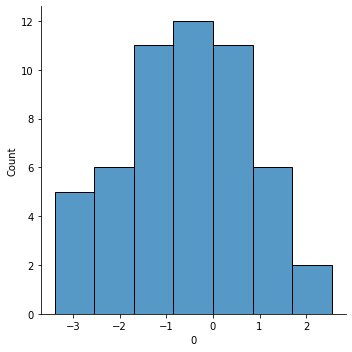

In [107]:
sns.displot(cluster1, x=0)

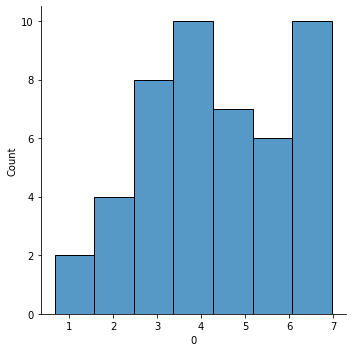

In [108]:
sns.displot(cluster2, x=0)

In [109]:
cluster1['label'][:] = 0
cluster1.head()

,0,1,label,kmeans_label
id_sub,,,,
103515,2.547560,-5.097945,0,0
152225,-0.450631,-1.287590,0,0
468050,-2.288567,-6.751728,0,0
969476,-0.942291,-5.491501,0,0
116726,-0.500926,-4.535259,0,0


In [110]:
SPAM_centers_c1 = [0]
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=0, FWHM=1)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


In [111]:
cluster2['label'][:] = 0

In [112]:
SPAM_centers_c2 = [4.5]
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=0, FWHM=1)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


In [113]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]+list(SPAM_vols_c2.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, smoothRate=0.2,
                    threshold="90%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)]=dtx.mesh.shift_aims_mesh_along_axis(mesh, 10*dist)

100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


#### Visualization of average crops of both clusters

In [114]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

#### Saving of average crops

In [115]:
# for x, mesh in tqdm(shifted_SPAM_meshes.items()):
#     aims.write(mesh, f"MA_{x}_2cluster.mesh")